In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from odc.stac import configure_rio
from dask_jobqueue import SLURMCluster
from dask.distributed import Client as daskClient
from dask import compute as dask_compute
from xarray import open_zarr as xr_open_zarr

from stacathome.walltowall import MaxiCube

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

# Construct Cube Object

In [3]:
aoi='somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 20  # 0.00018
chunksize_xy = 256

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

mxc = MaxiCube(aoi=aoi,
            requested_bands=requested_bands,
            crs=32737,  # 4326,
            resolution=resolution,
            chunksize_xy=chunksize_xy,
            chunksize_t=1000,
            path=out_path
            )

# Parallel request and download of tiles using SLURM

In [5]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='768MB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39451 instead
  warnings.warn(


Dashboard: http://10.0.30.56:39451/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:37353,Workers: 0
Dashboard: http://10.0.30.56:39451/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [22]:
process = mxc.download('2021-01-01', '2021-01-31')

In [24]:
client.close()
cluster.close()

In [6]:
process = mxc._parallel_request('2021-01-01', '2021-01-31')
mxc.save_items(process)

Assuming units of meters and grid size of 50 km for non 4326 crs!


In [ ]:
mxc.plot(subset_chunks_by=10)

# Load the requested data as on-the-fly xarray

In [11]:
mxc.request_items('2021-01-01', '2021-01-31', subset=0, new_request=True)
mxc.request_items('2021-01-01', '2021-01-31', subset=750)  # this will add the new request to the existing one, if there are new assets found
mxc.request_items('2021-01-01', '2021-01-31', subset=0, new_request=True)  # overwrite the existing list of requested assets

All data already downloaded.
51 missing assets of 13 items to download.
All data already downloaded.


In [13]:
otf_cube = mxc.load_otf_cube(mxc.req_items_local, 0, enlarge_by_n_chunks=4)
otf_cube

<xarray.Dataset> Size: 165MB
Dimensions:      (y: 1280, x: 2304, time: 7)
Coordinates:
  * y            (y) float64 10kB 1.136e+07 1.136e+07 ... 1.133e+07 1.133e+07
  * x            (x) float64 18kB 1.77e+06 1.77e+06 ... 1.816e+06 1.816e+06
    spatial_ref  int32 4B 32737
  * time         (time) datetime64[ns] 56B 2021-01-01T07:03:09.024000 ... 202...
Data variables:
    B02          (time, y, x) uint16 41MB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B03          (time, y, x) uint16 41MB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B04          (time, y, x) uint16 41MB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>
    B8A          (time, y, x) uint16 41MB dask.array<chunksize=(7, 256, 256), meta=np.ndarray>

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


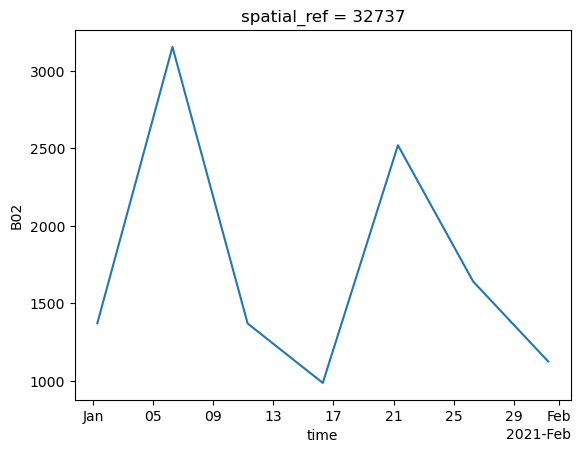

In [14]:
otf_cube.B02.mean(dim=[mxc.dimension_names['longitude'], mxc.dimension_names['latitude']]).plot()

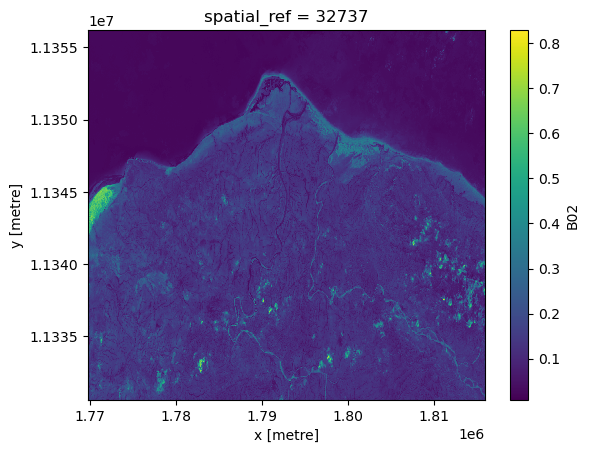

In [15]:
(otf_cube.B02.where(otf_cube.B02 != 0, np.nan).median(dim='time')/10000).plot()

In [16]:
mxc.save_items()

# Prepare to insert data into a larger consistent cube

In [17]:
# setup for large datacube
zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test_utm.zarr'
mxc.construct_large_cube(zarr_store, overwrite=False)

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test_utm.zarr. Skipping creation. Set overwrite=True to overwrite.


In [18]:
xr_open_zarr(zarr_store)

<xarray.Dataset> Size: 274TB
Dimensions:      (time: 3868, y: 75730, x: 58372)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 31kB 2015-06-01 2015-06-02 ... 2026-01-01
  * x            (x) float64 467kB -6.218e+05 -6.218e+05 ... 5.456e+05 5.456e+05
  * y            (y) float64 606kB 1.328e+06 1.328e+06 ... -1.863e+05 -1.863e+05
Data variables:
    B02          (time, y, x) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B03          (time, y, x) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B04          (time, y, x) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>
    B8A          (time, y, x) float32 68TB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>

In [19]:
tasks = mxc.fill_large_cube(subset=[0, 1], kind='requested', dask=True)
tasks

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test_utm.zarr. Skipping creation. Set overwrite=True to overwrite.


[Delayed('delayed_store_chunks_to_zarr-473a13b3-2856-4066-ad52-f417545b0009'),
 Delayed('delayed_store_chunks_to_zarr-74b92562-4104-474f-9c23-b926e5e7f5c5'),
 Delayed('delayed_store_chunks_to_zarr-957b876c-7cb9-4747-a19c-97d7ea0b7def'),
 Delayed('delayed_store_chunks_to_zarr-9ae5a353-d6d3-4fdc-96ff-d0edd038f474'),
 Delayed('delayed_store_chunks_to_zarr-cffc2779-6a7c-4972-a0f6-9e75add0f1b5'),
 Delayed('delayed_store_chunks_to_zarr-16c3cf2f-3f94-4ad9-bf0c-9e9faf29cb24'),
 Delayed('delayed_store_chunks_to_zarr-f893c4dc-b077-4cf6-9025-7058bc292ae0'),
 Delayed('delayed_store_chunks_to_zarr-6aa3964d-fff2-4990-9d33-7c75feb8b095')]

# Save the current cube into large dataset

In [20]:
# Create a SLURM cluster
# Create a SLURM cluster
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='32GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster
# # Create delayed tasks
# tasks = [fixed_function(i) for i in requested_bands]
# Trigger the execution of these tasks in parallel
# dask.compute(*tasks)

Dashboard: http://10.0.30.56:39677/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:38923,Workers: 0
Dashboard: http://10.0.30.56:39677/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [21]:
_ = dask_compute(*tasks)


In [22]:
client.close()
cluster.close()

# Addressing the large dataset as a minicube

In [25]:
mc_int = mxc.get_chunk(0, ('2021-01-01', '2021-01-31')).compute()
mc_int  

<xarray.Dataset> Size: 16MB
Dimensions:      (time: 31, y: 256, x: 256)
Coordinates:
    spatial_ref  int32 4B 32639
  * time         (time) datetime64[ns] 248B 2021-01-01 2021-01-02 ... 2021-01-31
  * x            (x) float64 2kB 4.482e+05 4.482e+05 ... 4.533e+05 4.533e+05
  * y            (y) float64 2kB 1.328e+06 1.328e+06 ... 1.323e+06 1.323e+06
Data variables:
    B02          (time, y, x) uint16 4MB 200 187 186 198 213 ... 848 841 847 833
    B03          (time, y, x) uint16 4MB 152 154 147 155 ... 1467 1433 1424 1395
    B04          (time, y, x) uint16 4MB 105 95 105 109 102 ... 924 854 843 886
    B8A          (time, y, x) uint16 4MB 102 93 92 95 93 91 ... 116 75 85 55 143

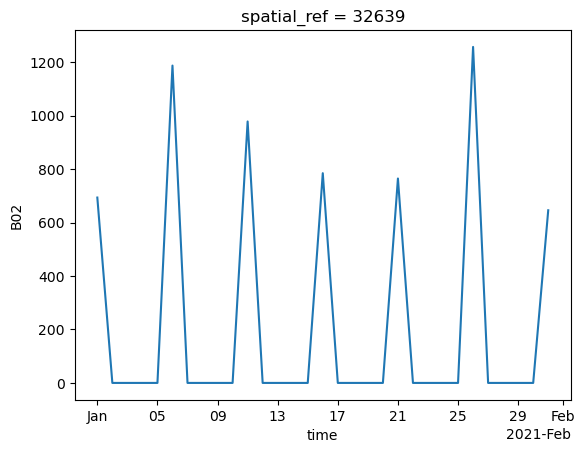

In [28]:
mc_int.B02.mean(dim=[mxc.dimension_names['latitude'], mxc.dimension_names['longitude']]).plot()

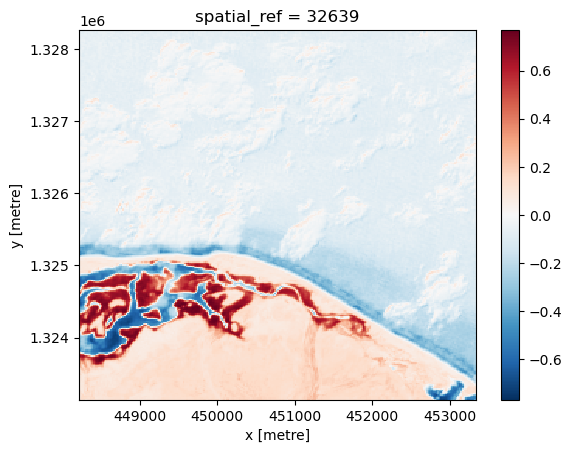

In [29]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)

mc_float = mc_int.where(mc_int.B02 != 0, np.nan).dropna(dim='time', how='all')
ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()

In [31]:
mc_drop_fill = mxc.get_chunk(0, ('2021-01-01', '2021-01-31'), drop_fill=True).compute()
mc_drop_fill

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 7, y: 256, x: 256)
Coordinates:
    spatial_ref  int32 4B 32639
  * time         (time) datetime64[ns] 56B 2021-01-01 2021-01-06 ... 2021-01-31
  * x            (x) float64 2kB 4.482e+05 4.482e+05 ... 4.533e+05 4.533e+05
  * y            (y) float64 2kB 1.328e+06 1.328e+06 ... 1.323e+06 1.323e+06
Data variables:
    B02          (time, y, x) uint16 918kB 200 187 186 198 ... 848 841 847 833
    B03          (time, y, x) uint16 918kB 152 154 147 155 ... 1433 1424 1395
    B04          (time, y, x) uint16 918kB 105 95 105 109 ... 924 854 843 886
    B8A          (time, y, x) uint16 918kB 102 93 92 95 93 ... 116 75 85 55 143

In [38]:
mxc.request_items('2015-01-01', '2026-01-31', subset=750, new_request=True)

4624 missing assets of 1156 items to download.


In [39]:
otf_cube = mxc.load_otf_cube(mxc.req_items_local, mxc.subset(chunk_id=750)[0])
otf_cube

<xarray.Dataset> Size: 308MB
Dimensions:      (y: 256, x: 256, time: 587)
Coordinates:
  * y            (y) float64 2kB 1.125e+07 1.125e+07 ... 1.124e+07 1.124e+07
  * x            (x) float64 2kB 1.821e+06 1.821e+06 ... 1.826e+06 1.826e+06
    spatial_ref  int32 4B 32737
  * time         (time) datetime64[ns] 5kB 2015-10-05T07:13:46.027000 ... 202...
Data variables:
    B02          (time, y, x) uint16 77MB dask.array<chunksize=(587, 256, 256), meta=np.ndarray>
    B03          (time, y, x) uint16 77MB dask.array<chunksize=(587, 256, 256), meta=np.ndarray>
    B04          (time, y, x) uint16 77MB dask.array<chunksize=(587, 256, 256), meta=np.ndarray>
    B8A          (time, y, x) uint16 77MB dask.array<chunksize=(587, 256, 256), meta=np.ndarray>

797 missing assets of 230 items to download.


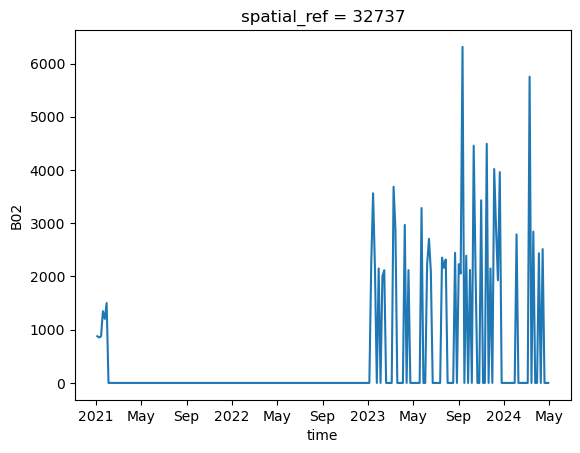

In [57]:
subset = 1070
mxc.request_items('2021-01-01', '2024-05-01', subset=subset, new_request=True)
otf_cube = mxc.load_otf_cube(mxc.req_items_local, subset=subset, enlarge_by_n_chunks=0, drop_fill=True)

In [26]:
from rasterio.windows import Window
from rasterio.errors import RasterioIOError, WarpOperationError
from  rasterio import open as rio_open


def check_asset(item):
    not_found, read_failed = [], []
    for a in item.assets:
        path = item.assets[a].href
        if not path.startswith('/Net') or not os.path.exists(path):
            not_found.append(path)
            continue
        try:
            #with rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', VSI_CACHE=True, ):
            with rio_open(path) as src:
                src.read(1, window=Window(0,0,256,256))  # src.width//2 - 128, src.height//2 - 128, 
                                          #src.width//2 + 128, src.height//2 + 128))
        except RasterioIOError:
            not_found.append(path)
        except WarpOperationError: 
            read_failed.append(path)
        except Exception as e:
            read_failed.append(path + f' {e}')
    return not_found, read_failed


In [27]:
from tqdm import tqdm
# this will take a while, but failed in SLURM
res=[]
for i in tqdm(mxc.items_local_global):
    res.append(check_asset(i))

100%|██████████| 2945/2945 [05:33<00:00,  8.82it/s] 


In [35]:
not_found, read_failed = [], []
for r in res:
    if len(r[0]) > 0:
        not_found.extend(r[0])
    if len(r[1]) > 0:
        read_failed.extend(r[1])

for i in not_found:
    if os.path.exists(i):
        print(i, os.path.getsize(i)//1000000)
        os.remove(i)
    else: 
        print('not exist:', i)